In [4]:
# combine the results

import json
import os
import numpy as np
import pandas as pd
from utils import test_results_post_process


PATH = ''
config = 'all_subject_leave_story'
num_folders = 6
paths = []

calc_acc_func = 'mean'
weights = [0.5, 0.5]
new_path = f'{config}_fuse_1'

for version in range(num_folders):
    predictions_list = []
    for path in paths:
        with open(f'{path}/version_{version}/test_results.json', 'r') as f:
            results = json.load(f)
            predictions = np.array(results['predictions'])[:, :, :2]
            # softmax
            predictions = np.exp(predictions)
            predictions = predictions / np.sum(predictions, axis=-1, keepdims=True)
            predictions_list.append(predictions)
            labels = results['labels']

    if calc_acc_func == 'oracle':
        for i in range(len(predictions_list)):
            predictions_list[i] = np.argmax(predictions_list[i], axis=-1)
            predictions_list[i] = np.equal(predictions_list[i], labels)
        results = np.any(predictions_list, axis=0)

    elif calc_acc_func == 'mean':
        predictions = np.average(predictions_list, axis=0, weights=weights)
        predictions = np.argmax(predictions, axis=-1)
        results = np.equal(predictions, labels)

    acc = np.sum(results, axis=-1) / results.shape[-1]

    if not os.path.exists(f'{PATH}/{new_path}/version_{version}'):
        os.makedirs(f'{PATH}/{new_path}/version_{version}')

    if config == 'all_subject_leave_story' or config == 'all_subject_per_trial':
        acc_dict = {f'S{i+1}': acc[i] for i in range(len(acc))}
        acc_dict.update({'mean': np.mean(acc)})
        acc_dict.update({'median': np.median(acc)})
        with open(f'{PATH}/{new_path}/version_{version}/test_accuracy.json', 'w') as f:
            json.dump(acc_dict, f, indent=4)

    elif config == 'leave_subject':
        with open(f'{PATH}/{new_path}/version_{version}/test_accuracy.json', 'w') as f:
            json.dump({'test/accuracy': acc[0]}, f, indent=4)

test_results_post_process(save_dir='new_logs', path=new_path, config=config, run=3)
accs = pd.read_csv(f'{PATH}/{new_path}/test_accuracy_all.csv')
acc = accs.iloc[16]['mean']
print(acc)

0.836204594017094


In [ ]:
# get the names of 64 EEG channels

import json
from mat4py import loadmat


raw_path = ''
dataset_path = ''
raw_file = loadmat(f"{raw_path}/S1.mat")['trials']
channel_label = raw_file[0]['FileHeader']['Channels']['Label']

with open(f'{dataset_path}/channel_names.json', 'w') as f:
    json.dump(channel_label, f, indent=4)

In [2]:
# summary the data according to the decrease of accuracy after excluding a channel
import json
import pandas as pd


channels = 64
standard_folder = ''
log_dir = ''
save_path = ''

def get_acc(path):
    accs = pd.read_csv(f'{log_dir}/{path}/test_accuracy_all.csv')
    acc = accs.iloc[16]['mean']
    return acc

channel_path = ''
with open(channel_path, 'r') as f:
        channel_names = json.load(f)

standard_acc = get_acc(standard_folder)
channel_accs = []
for channel in range(channels):
    log_folder = ''
    path = f'{log_folder}/channel_{channel}'
    acc = get_acc(path)
    acc = standard_acc - acc
    if acc < 0:
        print(f'channel_{channel} {channel_names[channel]}: {acc}')
    channel_accs.append(acc)
print(channel_accs)
with open(save_path, 'w') as f:
     json.dump(channel_accs, f)

channel_16 CP5: -0.0033253155027825887
channel_19 P1: -0.002270292490720749
channel_24 PO7: -0.0006009585534532125
channel_25 PO3: -0.001696040853857883
channel_48 C2: -0.0017628129571675144
channel_60 P10: -0.006904376981158977
[0.022783124198516247, 0.09963942877948284, 0.009001072806616772, 0.053151713373760456, 0.028859515053530682, 0.023744664775828594, 0.03844818783303117, 0.013741991793116082, 0.010096155107021332, 0.02032585969815659, 0.006904383810858006, 0.060349896860619534, 0.07041934132575989, 0.0018162444854776805, 0.006797546831270096, 0.01185897706697392, -0.0033253155027825887, 0.008266566010812992, 0.012606845237314812, -0.002270292490720749, 0.010790602614482392, 0.00811966384450602, 0.00865385215729475, 0.00753205517927813, -0.0006009585534532125, -0.001696040853857883, 0.013514961736897702, 0.0002003265544772148, 0.007665603111187691, 0.021287400896350617, 0.0006810932730635377, 0.013715282392998684, 0.08448184219499433, 0.06444978869209694, 0.11310096488644683, 0.

Creating RawArray with float64 data, n_channels=16, n_times=1280
    Range : 0 ... 1279 =      0.000 ...     9.992 secs
Ready.
Using matplotlib as 2D backend.


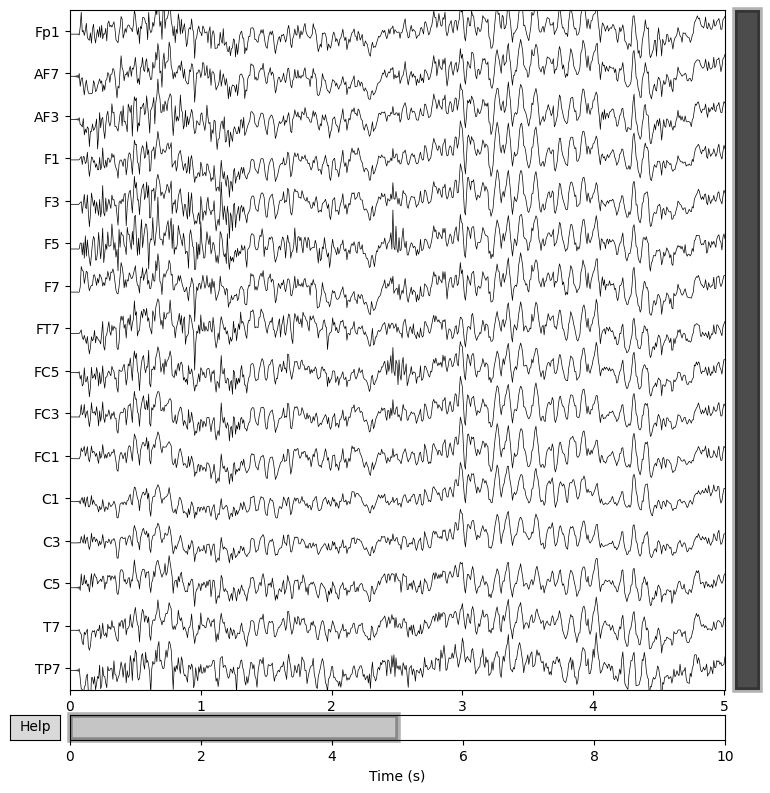

In [1]:
# plot EEG data for paper

import json
import mne
import os
import numpy as np
from mne.channels import make_standard_montage

channel_name_path = ""

with open(channel_name_path, 'r') as f:
    channel_names = json.load(f)
    montage = make_standard_montage('biosemi64')
    info = mne.create_info(ch_names=channel_names[:16], sfreq=128, ch_types='eeg')
    info.set_montage(montage)
    
subject = 1
eegdata_path = ''
subject_eegdata_path = f'{eegdata_path}/S{subject}'
files = [f for f in os.listdir(subject_eegdata_path) if f.endswith('.npy')]
assert len(files) == 8

file = files[0]
eegdata = np.load(f'{subject_eegdata_path}/{file}')
eegdata = eegdata.T
raw = mne.io.RawArray(eegdata[:16, :1280], info)
fig = raw.plot(duration=5, n_channels=16, scalings=20, show_scalebars=False)